## Put in Terminal:
mkdir -p "/content/Video Data"

cd "/content/Video Data"

curl data.yt8m.org/download.py | shard=1,100 partition=2/frame/train mirror=us python


## Parse Record Function

In [ ]:
import tensorflow as tf
import pandas as pd

def parse_tfrecord_fn(example):

    context_features = {     # Define context features (non-sequential data)
        "id": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.VarLenFeature(tf.int64)
    }

    sequence_features = {     # Define sequence features (per-frame data)
        "rgb": tf.io.FixedLenSequenceFeature([], dtype=tf.string),
        "audio": tf.io.FixedLenSequenceFeature([], dtype=tf.string)
    }

    context, sequence = tf.io.parse_single_sequence_example(       # Parse the context and sequence features from the TFRecord
        example, context_features=context_features, sequence_features=sequence_features
    )

    video_id = context["id"]     # Extract video ID

    # Extract labels and select the top 3 (or less if there are fewer than 3 labels)
    labels = tf.sparse.to_dense(context["labels"])   # Converts sparse tensor to dense
    labels = labels[:3]  # Take the top 3 labels (first 3 as they appear)

    # Decode RGB and audio features, keeping them as 8-bit integers
    rgb_frames = tf.map_fn(lambda x: tf.io.decode_raw(x, tf.uint8), sequence["rgb"], dtype=tf.uint8)
    audio_features = tf.map_fn(lambda x: tf.io.decode_raw(x, tf.uint8), sequence["audio"], dtype=tf.uint8)

    # Reshape the RGB and audio frames to their correct dimensions
    rgb_frames = tf.reshape(rgb_frames, [-1, 1024])  # Each frame has 1024 features
    audio_features = tf.reshape(audio_features, [-1, 128])  # Each frame has 128 features

    return video_id, labels, rgb_frames, audio_features


### Extract in dataset format and test one


In [ ]:
tfrecord_files = tf.data.Dataset.list_files("/content/Video Data/*.tfrecord")
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(parse_tfrecord_fn)
dataset = dataset.shuffle(buffer_size=100).batch(1).prefetch(tf.data.experimental.AUTOTUNE)

# Take a single example and display its contents
for example in dataset.take(1):
    video_id, labels, rgb_frames, audio_features = example

    # Display each part of the example
    print("Video ID:", video_id.numpy())
    print("Labels:", labels.numpy())
    print("RGB Frames shape:", rgb_frames.shape)
    print("Audio Features shape:", audio_features.shape)


Video ID: [b'InUY']
Labels: [[ 4  9 10]]
RGB Frames shape: (1, 201, 1024)
Audio Features shape: (1, 201, 128)


#### Helper Functions to see our data

In [ ]:
def see_data(dataset):
  for eg in dataset.take(1):
    print(eg[0].shape)
    print(eg[1])

In [ ]:
def see_data2(dataset):
  for eg in dataset.take(1):
    print(eg[0].shape)
    print("Shape of labels", len(eg[1]))
    print("first label", eg[1][0])
    print("second label", eg[1][0])
    print("third label", eg[1][0])

In [ ]:
import tensorflow as tf

# Check if a GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
    print("GPU Details: ", gpus)
else:
    print("No GPU available.")

No GPU available.


In [ ]:
from google.colab import files

def save_and_download_model(model, filename):
    """
    Save the Keras model and download it to the local machine.

    Parameters:
    model (tf.keras.Model): The Keras model to save.
    filename (str): The name of the file to save the model as.
    """
    # Save the model
    model.save(filename)

    # Download the model
    files.download(filename)

# Example usage:
# Assuming `model_optimized_single` is your trained model
#save_and_download_model(model_optimized_single, 'optimized_single_label_model.keras')

# Data Pre-Processing

## Padding

In [ ]:
def filter_empty_sequences(id, labels, rgb_frames, audio_features):
    # Check if rgb_frames and audio_features have valid lengths
    if tf.shape(rgb_frames)[1] > 0 and tf.shape(audio_features)[1] > 0:
        return True  # Keep this sequence
    else:
        return False  # Filter out this sequence

# Apply the filter to your dataset
dataset = dataset.filter(lambda id, labels, rgb_frames, audio_features: filter_empty_sequences(id, labels, rgb_frames, audio_features))


In [ ]:
for eg in dataset.take(1):
  print(eg[0].shape)
  print(eg[1].shape)
  print(eg[2].shape)
  print(eg[3].shape)

(1,)
(1, 1)
(1, 183, 1024)
(1, 183, 128)


In [ ]:
def pad_or_truncate_frames(id, label_element, rgb_frames, audio_features, max_frames=300):
    # Get the shape of the input frames
    rgb_shape = tf.shape(rgb_frames)

    label_element = tf.cond(  # Check if there are less than 3 labels
    tf.shape(label_element)[1] < 3,
    lambda: tf.concat([label_element, tf.tile(label_element[:, :1], [1, 3 - tf.shape(label_element)[1]])], axis=1),
    lambda: label_element[:, :3])


    # Check if the current number of frames is less than max_frames
    if rgb_shape[1] < max_frames:
        # Pad the RGB frames
        rgb_padded = tf.pad(rgb_frames, [[0, 0], [0, max_frames - rgb_shape[1]], [0, 0]])  # Keep batch size, pad frames
    else:
        # Truncate the RGB frames if it exceeds max_frames
        rgb_padded = rgb_frames[:, :max_frames, :]  # Keep batch size, truncate frames

    # Get the shape of the audio features
    audio_shape = tf.shape(audio_features)

    # Check if the current number of frames is less than max_frames
    if audio_shape[1] < max_frames:
        # Pad the audio features
        audio_padded = tf.pad(audio_features, [[0, 0], [0, max_frames - audio_shape[1]], [0, 0]])  # Keep batch size, pad features
    else:
        # Truncate the audio features if it exceeds max_frames
        audio_padded = audio_features[:, :max_frames, :]  # Keep batch size, truncate features

    return id, label_element, rgb_padded, audio_padded


# Use *args unpacking to handle each component separately
padded_dataset = dataset.map(lambda *x: pad_or_truncate_frames(*x))

In [ ]:

import tensorflow as tf

def truncate_frames(id, label_element, rgb_frames, audio_features, min_frames=300):
    # Truncate the frames to min_frames
    rgb_truncated = rgb_frames[:, :min_frames, :]
    audio_truncated = audio_features[:, :min_frames, :]

    # Ensure label has exactly 3 elements, padding if needed
    label_processed = tf.cond(
        tf.shape(label_element)[1] < 3,
        lambda: tf.concat([label_element, tf.tile(label_element[:, :1], [1, 3 - tf.shape(label_element)[1]])], axis=1),
        lambda: label_element[:, :3]
    )

    return id, label_processed, rgb_truncated, audio_truncated

filtered_dataset = dataset.filter(
    lambda id, label_element, rgb_frames, audio_features:
    tf.logical_and(tf.shape(rgb_frames)[1] >= 300, tf.shape(audio_features)[1] >= 300 )
)

# Then truncate frames in the filtered dataset
padded_dataset = filtered_dataset.map(lambda *x: truncate_frames(*x))


In [ ]:
for eg in padded_dataset.take(1):
    print(eg[0].shape)  # Should remain (1,)
    print(eg[1].shape)  # Should remain (1, 3)
    print(eg[2].shape)  # Should be (1, 300, 1024)
    print(eg[3].shape)  # Should be (1, 300, 128)

(1,)
(1, 3)
(1, 300, 1024)
(1, 300, 128)


## Concatenating Features and removing Id

In [ ]:
def concatenate_features(id_element, label_element, rgb_frames, audio_features):
    # Concatenate RGB frames and audio features along the last dimension
    concatenated_features = tf.concat([rgb_frames, audio_features], axis=-1)  # Shape: (1, 300, 1152)

    # Return the new dataset structure
    return (concatenated_features, label_element)

# Update the dataset to concatenate features
concatenated_dataset = padded_dataset.map(lambda *x: concatenate_features(*x))


In [ ]:
for eg in concatenated_dataset.take(1):
    print(eg[0].shape)  # Features
    print(eg[1].shape)  # Labels

(1, 300, 1152)
(1, 3)


In [ ]:
map_data = pd.read_csv("/content/vocabulary (3).csv")
map_data.head()
mapping = dict(zip(map_data['Index'], map_data['Vertical1']))

In [ ]:
# Create a unique integer ID for each string label
unique_labels = map_data['Vertical1'].unique()
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}

# Update the mapping dictionary to use integer IDs instead of strings
mapping = {idx: label_to_id[label] for idx, label in zip(map_data['Index'], map_data['Vertical1'])}

# Convert the updated mapping dictionary to a TensorFlow lookup table
keys_tensor = tf.constant(list(mapping.keys()), dtype=tf.int64)
values_tensor = tf.constant(list(mapping.values()), dtype=tf.int64)
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys_tensor, values_tensor),
    default_value=-1  # Default for unmapped labels
)

# Optionally, print the label to ID mapping to verify
print("Label to ID mapping:", label_to_id)

Label to ID mapping: {'Games': 0, 'Autos & Vehicles': 1, 'Arts & Entertainment': 2, 'Food & Drink': 3, 'Sports': 4, 'Pets & Animals': 5, 'Internet & Telecom': 6, 'Computers & Electronics': 7, 'Shopping': 8, 'Beauty & Fitness': 9, 'Hobbies & Leisure': 10, 'Business & Industrial': 11, 'Home & Garden': 12, 'Travel': 13, 'Science': 14, 'News': 15, 'Law & Government': 16, 'Real Estate': 17, 'Jobs & Education': 18, 'Reference': 19, '(Unknown)': 20, 'Books & Literature': 21, 'People & Society': 22, 'Health': 23, 'Finance': 24}


In [ ]:
def map_labels(features, labels):
    # Apply the lookup table to map labels
    mapped_labels = tf.map_fn(lambda label: table.lookup(label), labels, dtype=tf.int64)
    return features, mapped_labels

# Update dataset processing to apply only label mapping
def process_and_map_labels(dataset):
    return dataset.map(lambda features, labels: map_labels(features, labels))

# Assuming 'concatenated_dataset' is your input dataset
processed_dataset = process_and_map_labels(concatenated_dataset)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
for example in processed_dataset.take(1):
    feature, labels = example

    # Display each part of the example
    print("Labels:", labels.numpy())
    print("Features", feature.shape)


Labels: [[0 0 0]]
Features (1, 300, 1152)


---

In [ ]:
# # Count the number of instances in the dataset
# dataset_size = sum(1 for _ in processed_dataset)
# print("Dataset size:", dataset_size)
dataset_size = 41393

Dataset size: 41393
5 batch =194624


## Making Training, Validation and Test Data

In [ ]:

# Step 1: Separate Features and Labels
# Adjusted function to unpack the dataset correctly
def map_to_features_labels(*args):
    features = args[0]  # Assuming the first argument is the features
    labels = args[1]    # Assuming the second argument is the labels
    return features, labels


# Apply the mapping function to create a dataset of (features, labels) tuples
separated_dataset = processed_dataset.map(map_to_features_labels)


In [ ]:
# Get the total number of examples in the dataset
dataset_size = 41393

# Define split ratios
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size *0.15)

# Create training, validation, and test datasets
train_dataset = separated_dataset.take(train_size)
val_dataset = separated_dataset.skip(train_size).take(val_size)
test_dataset = separated_dataset.skip(train_size + val_size)

In [ ]:
# Batch and prefetch the datasets
batch_size = 32  # Adjust as needed
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# # Function to print shapes of a few samples
def print_sample_shapes(dataset, num_samples=1):
    for features, labels in dataset.take(num_samples):
        print("Features shape:", features.shape)
        print("Labels shape:", labels.shape)

# # Print shapes for train, validation, and test datasets
print("Train Dataset Sample Shapes:")
print_sample_shapes(train_dataset)

# print("\nValidation Dataset Sample Shapes:")
# print_sample_shapes(val_dataset)

# print("\nTest Dataset Sample Shapes:")
# print_sample_shapes(test_dataset)


Train Dataset Sample Shapes:
Features shape: (32, 1, 300, 1152)
Labels shape: (32, 1, 3)


Features shape: (32, 1, 300, 1152)
Labels shape: (32, 1, 3)

In [ ]:
def reshape_features_labels(features, labels):
    # Print original shapes for debugging
    print("Original features shape:", features.shape)
    print("Original labels shape:", labels.shape)

    # Remove dimensions of size 1
    features = tf.squeeze(features, axis=1)  # Resulting shape: (32, 300, 1152)
    labels = tf.squeeze(labels, axis=1)      # Resulting shape: (32, 3)

    return features, labels

# Apply the reshape function to the datasets
train_dataset = train_dataset.map(reshape_features_labels)
val_dataset = val_dataset.map(reshape_features_labels)
test_dataset = test_dataset.map(reshape_features_labels)

# Now check the shapes again
def print_sample_shapes(dataset):
    for features, labels in dataset.take(1):
        print("Features shape:", features.shape)
        print("Labels shape:", labels.shape)

# Check the new shape


Original features shape: (None, None, None, 1152)
Original labels shape: (None, None, None)
Original features shape: (None, None, None, 1152)
Original labels shape: (None, None, None)
Original features shape: (None, None, None, 1152)
Original labels shape: (None, None, None)


In [ ]:
print_sample_shapes(train_dataset)

Features shape: (32, 300, 1152)
Labels shape: (32, 3)


## One hot Encoding of Labels

In [ ]:
def one_hot_encode_labels(features, labels, num_classes):
    # Convert labels to one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_classes)
    return features, one_hot_labels

In [ ]:
# Define the number of classes for one-hot encoding (e.g., 25)
num_classes = 25  # Adjust based on your actual class count

# Apply one-hot encoding to the datasets
train_dataset_encoded = train_dataset.map(lambda features, labels: one_hot_encode_labels(features, labels, num_classes))
val_dataset_encoded = val_dataset.map(lambda features, labels: one_hot_encode_labels(features, labels, num_classes))
test_dataset_encoded = test_dataset.map(lambda features, labels: one_hot_encode_labels(features, labels, num_classes))

In [ ]:
for features, one_hot_labels in train_dataset_encoded.take(1):
    print(f"Features shape: {features.shape}, One-hot Labels shape: {one_hot_labels.shape}")

Features shape: (32, 300, 1152), One-hot Labels shape: (32, 3, 25)


In [ ]:
# see_data(train_dataset_encoded)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
#see_data(train_dataset_encoded)

In [ ]:
# we need three labels!!! of shape (32,25)

def prepare_data(features, labels):
    # Unpack the labels into separate tensors
    label_1 = labels[:, 0, :]  # Shape (32, 25)
    label_2 = labels[:, 1, :]  # Shape (32, 25)
    label_3 = labels[:, 2, :]  # Shape (32, 25)

    return features, (label_1, label_2, label_3)

# Map the dataset to split the labels
final_train_data = train_dataset_encoded.map(prepare_data)
final_val_data = val_dataset_encoded.map(prepare_data)
final_test_data = test_dataset_encoded.map(prepare_data)

In [ ]:
#see_data2(final_train_data);

In [ ]:
def prepare_single_label_data(features, labels):
    # Extract only the first label (label_1)
    label_1 = labels[:, 0, :]  # Shape (32, 25)
    return features, label_1

# Map the dataset to prepare inputs and outputs for a single label
final_single_train = train_dataset_encoded.map(prepare_single_label_data)
final_single_val = val_dataset_encoded.map(prepare_single_label_data)
final_single_test = test_dataset_encoded.map(prepare_single_label_data)

In [ ]:
see_data(final_single_train)

(32, 300, 1152)
tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0.

# Model Building

In [ ]:
print("running till here!")

running till here!


#### Multi- Simple Model - 35%

In [ ]:
from tensorflow.keras import layers, models

def build_multi_label_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Add LSTM layers
    x = layers.LSTM(256, return_sequences=True)(inputs)
    x = layers.LSTM(128)(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layers for each label
    output_1 = layers.Dense(num_classes, activation='softmax', name='label_1')(x)
    output_2 = layers.Dense(num_classes, activation='softmax', name='label_2')(x)
    output_3 = layers.Dense(num_classes, activation='softmax', name='label_3')(x)

    model = models.Model(inputs, outputs=[output_1, output_2, output_3])
    model.compile(optimizer='adam', loss={'label_1': 'categorical_crossentropy',
          'label_2': 'categorical_crossentropy',
          'label_3': 'categorical_crossentropy'}, metrics={'label_1': 'accuracy',
             'label_2': 'accuracy',
             'label_3': 'accuracy'})

    return model

# Build the model
model_multi = build_multi_label_model((300, 1152), 25)


#### Single Simple Model - 34%

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Ensure y_true and y_pred are of float type for calculations
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Compute the categorical cross-entropy
        cross_entropy = K.categorical_crossentropy(y_true, y_pred)

        # Expand dimensions to match shapes for element-wise multiplication
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # Stabilize to avoid log(0)
        weights = alpha * y_true * K.pow(1 - y_pred, gamma)

        # Ensure weights have the same shape as cross_entropy for broadcasting
        weights = tf.reduce_sum(weights, axis=-1)

        # Calculate focal loss
        focal_loss_value = weights * cross_entropy
        return focal_loss_value

    return focal_loss_fixed

def build_single_label_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Add LSTM layers
    x = layers.LSTM(512, return_sequences=True)(inputs)
    x = layers.LSTM(256)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)

    # Single output layer for one label
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])

    return model

# Build the model for one label (e.g., label 1)
model_single = build_single_label_model((300, 1152), 25)


#### Single High Complex Model - 17%

In [ ]:
from keras import layers, models

from keras import layers, models

def build_complex_single_label_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # First LSTM block with residual connection
    x = layers.LSTM(512, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(inputs)
    x = layers.BatchNormalization()(x)
    x_residual = layers.LSTM(512, return_sequences=True)(x)
    x = layers.Add()([x, x_residual])  # Residual connection

    # Second LSTM block
    x = layers.LSTM(512, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(x)
    x = layers.BatchNormalization()(x)

    # Third LSTM block with residual connection
    x_residual = layers.LSTM(256, return_sequences=False)(x)

    # Flatten and project to match the residual shape
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)  # Project flattened layer to match shape of x_residual
    x = layers.Add()([x, x_residual])  # Residual connection

    # Fully connected layers
    x = layers.Dense(256, activation='relu', kernel_regularizer='l2')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
    x = layers.Dropout(0.4)(x)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the model for one label (e.g., label 1)
model_complex_single = build_complex_single_label_model((300, 1152), 25)  ## -- 18% Accuracy


#### Single Balanced Model- 35%

In [ ]:
from keras import layers, models

def build_optimized_single_label_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # First LSTM block with residual connection
    x = layers.LSTM(256, return_sequences=True, dropout=0.2)(inputs)
    x = layers.BatchNormalization()(x)
    x_residual = layers.Dense(256)(x)  # Matching residual dimensions
    x = layers.Add()([x, x_residual])  # Residual connection

    # Second LSTM block with a smaller residual connection
    x = layers.LSTM(128, return_sequences=False, dropout=0.2)(x)
    x = layers.BatchNormalization()(x)
    x_residual = layers.Dense(128)(x)  # Matching residual dimensions
    x = layers.Add()([x, x_residual])

    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the model for one label (e.g., label 1)
model_optimized_single = build_optimized_single_label_model((150, 1152), 25)


---

#### More balanced single model

In [ ]:
def build_single_label_model(input_shape, num_classes, class_weights=None):
    inputs = layers.Input(shape=input_shape)

    # Add BatchNormalization after input
    x = layers.BatchNormalization()(inputs)

    # Add LSTM layers with dropout and recurrent dropout
    x = layers.LSTM(512, return_sequences=True,
                   dropout=0.3,
                   recurrent_dropout=0.3)(x)
    x = layers.BatchNormalization()(x)

    x = layers.LSTM(256,
                   dropout=0.3,
                   recurrent_dropout=0.3)(x)
    x = layers.BatchNormalization()(x)

    # Dense layers with dropout
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)

    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, output)

    # Use a lower learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(optimizer=optimizer,
                 loss=focal_loss(gamma=2.0, alpha=0.25),
                 metrics=['accuracy'])

    return model



# Usage example:
#class_weights = compute_class_weights(y_train)
model_single = build_single_label_model((300, 1152), 25)

# When training:
"""
history = model_single.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001
        )
    ]
)
"""

"\nhistory = model_single.fit(\n    X_train, y_train,\n    validation_data=(X_val, y_val),\n    epochs=100,\n    batch_size=32,\n    class_weight=class_weights,\n    callbacks=[\n        tf.keras.callbacks.EarlyStopping(\n            monitor='val_loss',\n            patience=10,\n            restore_best_weights=True\n        ),\n        tf.keras.callbacks.ReduceLROnPlateau(\n            monitor='val_loss',\n            factor=0.5,\n            patience=5,\n            min_lr=0.00001\n        )\n    ]\n)\n"

# Training

### Multi Simple

In [ ]:
# use final_train and val data
model_multi.fit(final_train_data, validation_data=final_val_data, epochs=5)

Epoch 1/5
   4258/Unknown 755s 177ms/step - label_1_accuracy: 0.3408 - label_2_accuracy: 0.3261 - label_3_accuracy: 0.3559 - loss: 6.6375

KeyboardInterrupt: 

### Single Simple

In [ ]:
#model_single.fit(final_single_train , epochs=2) # -- 34% consisent but stuck

Epoch 1/2
386/386 ━━━━━━━━━━━━━━━━━━━━ 89s 226ms/step - accuracy: 0.2817 - loss: 0.4450
Epoch 2/2


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


386/386 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.2924 - loss: 0.4119


#### Class Weights:

In [ ]:
import numpy as np
y_train = []
for _, labels in final_single_train.take(10000):  # Adjust number as needed
    y_train.extend(np.argmax(labels.numpy(), axis=1))
y_train = np.array(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))


In [ ]:
import pickle

# Your class_weight_dict

# Save to a pickle file
with open('class_weights.pkl', 'wb') as f:
    pickle.dump(class_weight_dict, f)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Train with class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# #y_train = np.argmax(final_single_train[1], axis=1) if final_single_train[1].ndim > 1 else final_single_train[1]

# # Calculate class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weight_dict = dict(enumerate(class_weights))

history = model_single.fit(
    final_single_train,
    epochs=5,  # Increased from 2 to give model more time to learn
    batch_size=320,
    validation_data= final_single_val,
    #class_weight=class_weight_dict,
    shuffle=True  # Important for balanced learning
)

Epoch 1/5
    236/Unknown 646s 3s/step - accuracy: 0.2804 - loss: 0.4468

KeyboardInterrupt: 

### Experimentation zone:

In [ ]:
history = model_complex_single.fit(final_single_train, validation_data=final_single_val , epochs=5) # -- 34% consisent but stuck

Epoch 1/5
    418/Unknown 1475s 4s/step - accuracy: 0.2026 - loss: 10.9403

KeyboardInterrupt: 

### model Complex singlke

In [ ]:
#history = model_complex_single.fit(final_single_train,validation_data= final_single_val , epochs=3) #- 18% accuracy

Epoch 1/3
      4/Unknown 8s 2s/step - accuracy: 0.1497 - loss: 13.0728

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


    906/Unknown 1594s 2s/step - accuracy: 0.2842 - loss: 6.4278

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


906/906 ━━━━━━━━━━━━━━━━━━━━ 1847s 2s/step - accuracy: 0.2842 - loss: 6.4259 - val_accuracy: 0.3457 - val_loss: 2.9228
Epoch 2/3
906/906 ━━━━━━━━━━━━━━━━━━━━ 1834s 2s/step - accuracy: 0.3444 - loss: 2.6752 - val_accuracy: 0.3507 - val_loss: 2.2104
Epoch 3/3
906/906 ━━━━━━━━━━━━━━━━━━━━ 1815s 2s/step - accuracy: 0.3504 - loss: 2.1780 - val_accuracy: 0.3547 - val_loss: 2.0695


In [ ]:
|history = model_single.fit(
    final_single_train,
    #validation_data=val_dataset_encoded,
    epochs=3,
    batch_size=32
)

Epoch 1/3
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 151ms/step - accuracy: 0.3367 - loss: 2.1806
Epoch 2/3


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.3530 - loss: 2.0814
Epoch 3/3
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.3595 - loss: 2.0818


KeyError: 'val_accuracy'

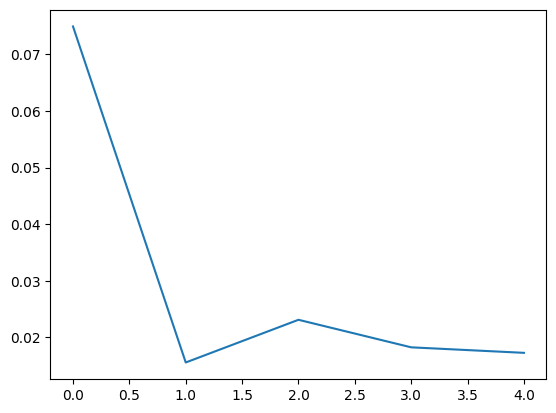

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save, load and Evaluate

In [ ]:
save_and_download_model(model_single, 'single_simple_trunc.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from sklearn.metrics import classification_report
# import numpy as np

# # Predict on test dataset
# y_pred = loaded_model.predict(test_dataset_encoded)
# #y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class for each instance

In [ ]:
# Assume true labels are in `y_test_encoded`
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes))


In [ ]:
#save_and_download_model(model_optimized_single, 'optimized_single_label_model.keras')

In [ ]:
 loaded_model = tf.keras.models.load_model('/content/vit_model.keras')

In [ ]:
final_single_test

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 1152), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 25), dtype=tf.float32, name=None))>

In [ ]:
prediction = loaded_model.predict(tf.gather(features, [0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#loaded_model = model_single

# Step 1: Get Predictions and True Labels from final_single_test
y_true = []
y_pred = []

# Iterate over the test dataset and collect true labels and predictions
for features, true_labels in final_single_test:
    predictions = loaded_model.predict(features)  # Get model predictions
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert probabilities to class labels
    y_true.extend(np.argmax(true_labels, axis=1))  # Convert one-hot true labels to class labels

# Step 2: Classification Report


### If multi-model : Convert to Single and Evaluate

In [ ]:
prediction[0]

array([[7.83737719e-01, 4.84920153e-03, 8.12117849e-03, 1.25067190e-05,
        2.00283170e-01, 7.82912175e-05, 4.94526757e-05, 1.72965039e-04,
        8.74764519e-05, 3.65080632e-05, 2.31166458e-04, 1.70453248e-04,
        3.43102547e-05, 7.96574896e-05, 2.10950893e-04, 4.84961987e-04,
        1.03500544e-03, 2.77348659e-06, 1.41811215e-05, 1.18187236e-04,
        1.21634133e-04, 4.39390096e-05, 9.01690692e-06, 2.79758888e-06,
        1.26153327e-05]], dtype=float32)

In [ ]:

# Step 1: Get Predictions and True Labels from final_single_test
y_true = []
y_pred = []

# Iterate over the test dataset and collect true labels and predictions
for features, true_labels in final_single_train:
    predictions = loaded_model.predict(features)  # Get model predictions
    y_pred.extend(np.argmax(predictions[0], axis=1))  # Convert probabilities to class labels
    y_true.extend(np.argmax(true_labels, axis=1))  # Convert one-hot true labels to class labels


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84      3646
           1       0.52      0.95      0.67      1279
           2       0.93      0.80      0.86      3562
           3       0.88      0.69      0.77       541
           4       0.70      0.29      0.41       646
           5       0.55      0.70      0.62       345
           6       0.39      0.83      0.53       246
           7       0.31      0.14      0.20       239
           8       0.43      0.21      0.29       256
           9       0.83      0.68      0.75       505
          10       0.00      0.00      0.00       289
          11       0.11      0.03      0.05       215
          12       0.00      0.00      0.00        95
          13       0.00      0.00      0.00        57
          14       0.00      0.00      0.00       120
          15       0.00      0.00      0.00        47
          16       0.00      0.00      0.00        37
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


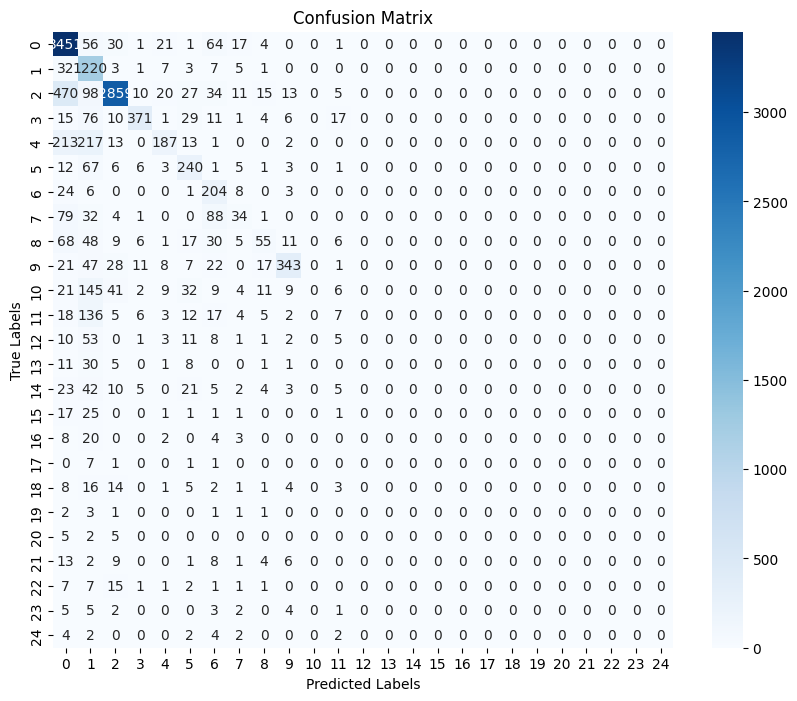

In [ ]:

# Step 3: Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
